### TODO's

- Want a bar graph for the success + failure rates
    - Could be a really straightforward visualization for each product
- QC side: want to be able to categorize what the types of failure are
- Make sure the admin settings are configured + others can view it clearly

In [1]:
# Imports
import boto3
import pandas as pd
import numpy as np
import pymysql
import datetime as dt
import aurora_data_api # https://github.com/cloud-utils/aurora-data-api


# Data Visualization/Analysis
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
port = 3306
user = 'admin'
password = 'password'
host1 = 'qaresults.cluster-cyvmmsfjcmrl.us-east-1.rds.amazonaws.com'
dbName1 = 'results'
resourceARN1 = 'arn:aws:rds:us-east-1:319481862133:cluster:qaresults'
secretARN1 = 'arn:aws:secretsmanager:us-east-1:319481862133:secret:QAResultsKey-4nTfK9'


In [3]:
# Burner Account Credentials
# db = aurora_data_api.connect(aurora_cluster_arn = resourceARN, secret_arn=secretARN, database="db3")
# c = db.cursor()

# Connection method 2
db = aurora_data_api.connect(aurora_cluster_arn = resourceARN1, secret_arn=secretARN1, database=dbName1)
c = db.cursor()

In [4]:
# General helper methods
def getDate():
    return dt.datetime.today().strftime('%Y-%m-%d') # YYYY-MM-DD


# Execute queries + display results
def execute(q):
    c.execute(q) # Execute the query
    return c.fetchall() # Display the output of said query

# 

# Create the initial QA Table
def createQATable():
    q = '''
        Create table if not exists QAResults(
            SerialNumber VARCHAR(30),
            BatchNumber VARCHAR(30),
            Date VARCHAR(10),
            Tester VARCHAR(20),
            FunctionalTest VARCHAR(4),
            FailureType text,
            LogMessage text,
            primary key (SerialNumber)
        )
    '''
    try:
        execute(q)
    except Exception as e:
        print('Issue with table creation:', e)

# Delete the QAResults table
def deleteTable():
    try:
        q = ''' DROP Table QAResults '''
        c.execute(q)
    except Exception as e:
        print('Error with deleting the table:', e)
        
# Helper method to get an entry (based off of SN alone)
def getEntry(sn):
    try:
        q = ''' SELECT * FROM QAResults where SerialNumber = '{}' '''.format(sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with get entry:', e)

# Helper method to insert an entry
def insertEntry(sn, bn, ft, tst, msg, fail = None, date = getDate()):
    try:
        q = ''' Insert into QAResults values ('%s', '%s', '%s', '%s', '%s', '%s', '%s')''' % (sn, bn, date, tst, ft, fail, msg)
        return execute(q)
        #executeQuery(q)
    except Exception as e:
        print('Issue with add entry:', e)

# Delete an entry based on SN alone
def deleteEntry(sn):
    try:
        q = ''' Delete from QAResults where SerialNumber = '%s' ''' % (sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with delete entry:', e)

# Modify a field based off of SN
def modifyEntry(sn, field, newVal):
    try:
        q = ''' Update QAResults set {} = '{}' where SerialNumber = '{}' '''.format(field, newVal,sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with edit entry:', e)

# Get all the results for the table
def displayAll():
    try:
        print('\n\nQAResults Table\n')
        q = ''' Select * From QAResults '''
        display(execute(q))
    except Exception as e:
        print('Issue with displaying table:', e)
        

# Convert into the tabular form... powerful
def convertToDF(tbl):
    try:
        df1 = pd.read_sql('''SELECT * FROM {} '''.format(tbl), con = db)
        return df1
    except Exception as e:
        print('error:', e)
# More comprehensive inserts into table

def newMassInsert():
    sampleDates1 = ['2020-12-15', '2021-01-15', '2021-02-15', '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15']
    sampleDates2 = ['2020-12-25', '2021-01-25', '2020-12-25', '2021-03-25', '2021-04-25', '2021-05-25', '2021-06-25']
    failureRates = [73,91,85,96,55,99] # By percentage terms
    failureTypes = ['None', 'Camera Issue', 'Lighting Issue', 'Night Mode Issue', 'Video Quality Issue', 'Other']
    snPrefix = ['EUHWQ3931-', 'ABC22', 'RRH43144', '283367144', 'teegfhj-22-thgf', 'dgdss']
    batchNums = ['EE1', 'FF2', 'GG3', 'HH4', 'II5']
    testers = ['Zach', 'Ryan', 'Ruohan', 'Nikki', 'Megan', 'Jordy']
    results = ['Pass', 'Fail']
    messages = ['Everything Works', 'Camera is not doing so hot', 'Night mode issue ensued', 'Other issue-unlisted']

    # Populate with 600 dummy entries
    for i in range(6):
        for j in range(100):
            sn = snPrefix[i] + str(j)
            # Generate the date of entry--staggered
            if j % 2 == 0:
                date = sampleDates1[i]
            else:
                date = sampleDates2[i]
            ft = 'Pass' if j < failureRates[i] else 'Fail' # Generate functional test result based on failure rate
            tester = testers[j % 6]
            batchNum = batchNums[j % 5]        
            if ft == 'Pass': # Can get a message + failure type based off of the functional test result
                msg = messages[0]
                fail = failureTypes[0]
            else:
                msg = messages[j % 4]
                fail = failureTypes[i % 3 + 1] if j < 20 else failureTypes[j % 5 + 1] 
            # sn, bn, res, t, msg, fail, d)
            insertEntry(sn, batchNum, ft, tester, msg, fail, date)
#display(convertToDF('QAResults')) # This is so clean--I love it!

In [9]:
createQATable()
newMassInsert()


In [35]:

# Functions + Variables to mass insert entries (consistently) into the database
# Old way to mass insert entries


def oldInserts():
    snPrefix = ['EUHWQ3931-', 'ABC22', 'RRH43144', '283367144']
    batchNums = ['EE1', 'FF2', 'GG3']
    testers = ['Zach', 'Ryan', 'Ruohan', 'Nikki', 'Megan']
    results = ['Pass', 'Fail']
    dates = [getDate(), '2020-05-02', '2020-06-09', '2019-11-27', '2021-04-19', '2021-04-01']
    messages = ['Camera is not doing so hot', 'Night mode issue ensued', 'Other issue-unlisted']
    passMsg = 'Everything works'
    failureTypes = ['None', 'Camera Issue', 'Lighting Issue', 'Night Mode Issue', 'Video Quality Issue', 'Other']

    def massInsertEntry(n):
        for i in range(n):
            sn = snPrefix[i % 4] + str(i)
            bn = batchNums[i % 3]
            t = testers[i % 5]
            res = results[int(i % 4 == 0)]
            d = dates[i % 6]
            if res == 'Pass':
                fail = failureTypes[0]
                msg = passMsg
            else:
                fail = failureTypes[i % 3 + 1] if i < 20 else failureTypes[i % 5 + 1] 
                msg = messages[i % 3]
            insertEntry(sn, bn, res, t, msg, fail, d)
    massInsertEntry(100)
oldInserts()

KeyboardInterrupt: 

In [7]:

# Date Queries--directly from SQL DB

# Must obtain an exact match
def getDay(date):
    q = ''' Select * from QAResults where Date = '{}' '''.format(date)
    return execute(q)

# Format: date is passed in as YYYY-MM to be matched against given dates
def getMonth(date):
    q = ''' Select * from QAResults where Substring(Date, 1, 7) = '{}' '''.format(date)
    return execute(q)

# Get all entries for a given year
def getYear(year):
    q = ''' Select * from QAResults where Substring(Date, 1, 4) = '{}' '''.format(year)
    return execute(q)

# Get all entries before a date (inclusive)
def getEntriesBefore(date):
    q = ''' Select * from QAResults where Date < '{}' '''.format(date)
    return execute(q)
    
# Get all entries after a date (inclusive)
def getEntriesAfter(date):
    q = ''' Select * from QAResults where Date >= '{}' '''.format(date)
    return execute(q)

# Get all the entries that fall b/w a specific start and end date
def getEntriesBetween(start, end):
    q = ''' Select * from QAResults where Date <= '{}' and Date >= '{}' '''.format(end, start)
    return execute(q)

In [ ]:

# Testing date framework
def testDateFunctions():
    day = '2021-04-19'
    month = '2021-06'
    year = '2019'
    startDay = '2021-04-19'
    endDay = '2021-06-10'
    print('\n\nGet entries on day:', day)
    display(getDay(day))
    print('\n\nGet entries on month:', month)
    display(getMonth(month))
    print('\n\nGet entries on year:', year)
    display(getYear(year))
    print('\n\nGet entries before day:', day)
    display(getEntriesBefore(day))
    print('\n\nGet entries after day:', day)
    display(getEntriesAfter(day))
    print('\n\nGet entries between:', startDay, 'and', endDay)
    display(getEntriesBetween(startDay, endDay))

testDateFunctions()

In [24]:
deleteTable()
createQATable()

In [7]:

#newMassInsert()

In [10]:
df = convertToDF('QAResults')
df.head(10) # Display the first 10 entries


,SerialNumber,BatchNumber,Date,Tester,FunctionalTest,FailureType,LogMessage
0,2833671440,EE1,2021-03-15,Zach,Pass,None,Everything Works
1,2833671441,FF2,2021-03-25,Ryan,Pass,None,Everything Works
2,28336714410,EE1,2021-03-15,Megan,Pass,None,Everything Works
3,28336714411,FF2,2021-03-25,Jordy,Pass,None,Everything Works
4,28336714412,GG3,2021-03-15,Zach,Pass,None,Everything Works
5,28336714413,HH4,2021-03-25,Ryan,Pass,None,Everything Works
6,28336714414,II5,2021-03-15,Ruohan,Pass,None,Everything Works
7,28336714415,EE1,2021-03-25,Nikki,Pass,None,Everything Works
8,28336714416,FF2,2021-03-15,Megan,Pass,None,Everything Works
9,28336714417,GG3,2021-03-25,Jordy,Pass,None,Everything Works


In [11]:
# Starting with trend visualization
display(df[df['FunctionalTest'] == 'Pass'].head()) # Show entries that pass
print('Passrate:' , sum((df['FunctionalTest'] == 'Pass'))/len(df))


,SerialNumber,BatchNumber,Date,Tester,FunctionalTest,FailureType,LogMessage
0,2833671440,EE1,2021-03-15,Zach,Pass,None,Everything Works
1,2833671441,FF2,2021-03-25,Ryan,Pass,None,Everything Works
2,28336714410,EE1,2021-03-15,Megan,Pass,None,Everything Works
3,28336714411,FF2,2021-03-25,Jordy,Pass,None,Everything Works
4,28336714412,GG3,2021-03-15,Zach,Pass,None,Everything Works


Passrate: 0.8316666666666667


Pass    499
Fail    101
Name: FunctionalTest, dtype: int64

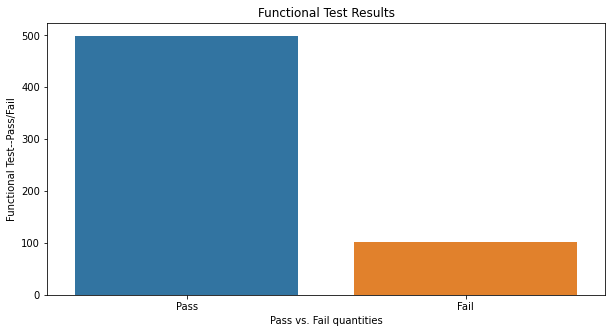

In [12]:
# Working with visualizations
byResult = df['FunctionalTest'].value_counts()
display(byResult)
#display(byResult)
plt.figure(figsize = (10, 5))
sns.barplot(x = byResult.index, y = byResult)
plt.title('Functional Test Results')
plt.xlabel('Pass vs. Fail quantities')
plt.ylabel('Functional Test--Pass/Fail');
#sns.barplot(y = 'FunctionalTest', data = df)

In [31]:
# Methods for trend visualization

# Raw counts for functional test results
def compareFunctionalTests(df, start = None, end = None):
    byResult = df['FunctionalTest'].value_counts()
    plt.figure(figsize = (10, 6))
    plt.legend(['Pass', 'Fail'])
    #plt.bar(x = byResult.index, height = byResult)
    plot = sns.barplot(x = byResult.index, y = byResult)
    if start == None and end == None:
        title = 'Functional Test Results: Across All Time' 
    elif start == None:
        title = 'Functional Test Results Up Until ' + str(end)
    elif end == None:
        title = 'Functional Test Results From ' + str(start) + ' To Present'
    else:
        title = 'Functional Test Results From ' + start + ' To ' + end
    plot.set(xlabel = 'Pass vs. Fail', ylabel = 'Functional Test-Raw Counts', title = title)
    
    
    return plot

# Get the relative counts
def relativeFunctionalTests(df, start = None, end = None):
    relativeRates = df['FunctionalTest'].value_counts(normalize = True)
    plt.figure(figsize = (10, 6))
    plot = sns.barplot(x = relativeRates.index, y = relativeRates)
    #plot.legend(['Pass', 'Fail'])
    if start == None and end == None:
        title = 'Functional Test Results By Proportion: Across All Time' 
    elif start == None:
        title = 'Functional Test Results By Proportion: Up Until ' + str(end)
    elif end == None:
        title = 'Functional Test Results By Proportion: From ' + str(start) + ' To Present'
    else:
        title = 'Functional Test Results From ' + start + ' To ' + end
    plot.set(xlabel = 'Pass vs. Fail', ylabel = 'Proportion Pass/Fail', title = title)
    return plot

# Failure rates by catgory (% of ALL entries that fall under each bucket)
def failureVisual(df, start = None, end = None):
    origSize = len(df) # Get the number of total entries
    byFailure = df['FailureType'].value_counts(normalize = True) * 100 # Get percentage of failure rates
    byFailure = byFailure.drop(labels = ['None']) # Don't need to retain the non-failure options
    plt.figure(figsize = (10, 6))
    plot = sns.barplot(x = byFailure.index, y = byFailure)
    if start == None and end == None:
        title = 'Common Failure Type Percentage: Across All Time' 
    elif start == None:
        title = 'Common Failure Type Percentage: Up Until ' + str(end)
    elif end == None:
        title = 'Common Failure Type Percentage: From ' + str(start) + ' To Present'
    else:
        title = 'Common Failure Type Percentage: ' + start + ' To ' + end
    plot.set(xlabel = 'Failure Category', ylabel = 'Percentage of Failure Type (%)', title = title)
    labels = ['Camera Issue', 'Lighting Issue', 'Night Mode Issue', 'Video Quality Issue', 'Other']
    #plt.legend(labels = labels, loc = 1) # Include a legend
    plt.show(plot)
    return plot

# Visualize the failure rate over time by time segments broken down by segment (days/weeks/months/years) + segLength
# Have the option to choose whether to have continuous over time or with NaN data show up as gaps
def failureOverTime(df, start, end, segType = 'day', x = 1, cont = True):
    startDate = dt.datetime.strptime(start, '%Y-%m-%d') # Get Datetime version
    endDate = dt.datetime.strptime(end, '%Y-%m-%d') # Get datetime version of the end
    failureRates = []
    while startDate <= endDate:
        if segType == 'day':
            tempEnd = startDate + pd.offsets.DateOffset(days = x) # Get the end date for end of a time chunk
        elif segType == 'month':
            tempEnd = startDate + pd.offsets.DateOffset(months = x)
        elif segType == 'week':
            tempEnd = startDate + pd.offsets.DateOffset(weeks = x)
        elif segType == 'year':
            tempEnd = startDate + pd.offsets.DateOffset(years = x)
        strStart = startDate.strftime('%Y-%m-%d') # Convert to the string version for START
        strEnd = tempEnd.strftime('%Y-%m-%d') # String vesion of END
        relEntries = df[(df['Date'] >= strStart) & (df['Date'] < strEnd)] # Keep only dates w/in a specific range
        if len(relEntries) != 0: # So long as some tests were conducted in the timeframe
            #display(relEntries)
            passRate = relEntries['FunctionalTest'].value_counts(normalize = True)['Pass'] # Find the Pass rate
            failRate = (1 - passRate) * 100 # Add in the failure rate
            #print(failDict)
            failureRates.append([startDate.date(), failRate])
        else: # Case where no entries were used
            failureRates.append([startDate.date(), np.nan])
        startDate = tempEnd
    
        
    failDF = pd.DataFrame(failureRates, columns = ['Start Date', 'Failure Rate'])
    #display(failDF)
    plt.figure(figsize = (10, 6))
    plt.xticks(rotation = 45)
    sns.set_style('darkgrid')
    if cont:
        plot = sns.lineplot(data = failDF, x = 'Start Date', y = 'Failure Rate') # Continuous plot
    else:
        plot = sns.pointplot(data = failDF, x = 'Start Date', y = 'Failure Rate') # Discrete points that are "connected"
    plot.set(xlabel = 'Start Date', ylabel = 'Failure Rate (%)', title = 'Change in Failure Rate Over Time from ' + start + ' to ' + end);

    
    return plot;



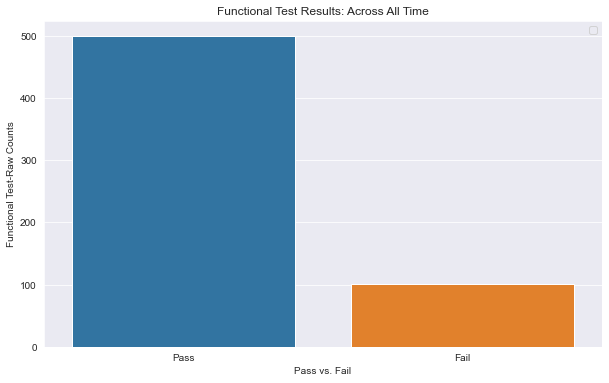

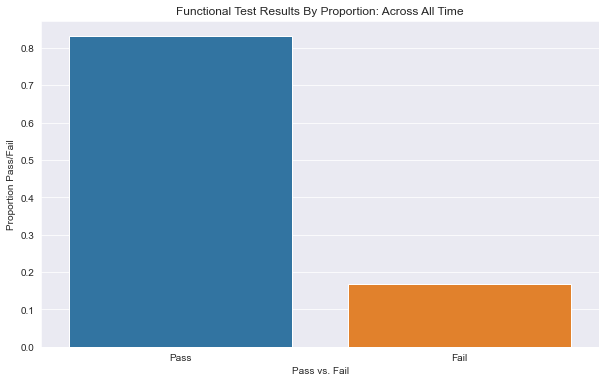

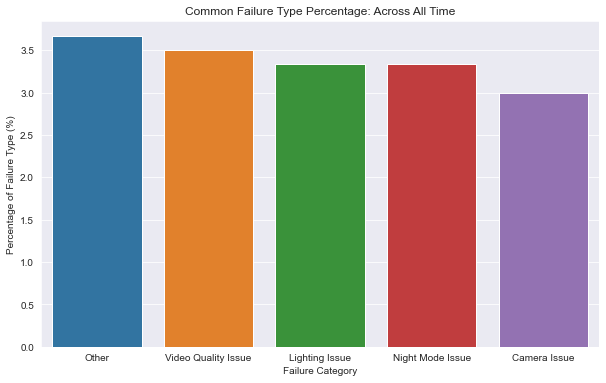

<Figure size 432x288 with 0 Axes>

In [32]:
# Testing basic functionality of graphing
compareFunctionalTests(df);
plt.savefig('funcTests.png')
relativeFunctionalTests(df);
plt.savefig('funcTestsRelative.png')
failureVisual(df);
plt.savefig('failureType.png');

,Start Date,Failure Rate
0,2021-03-10,4.0
1,2021-04-09,45.0
2,2021-05-09,1.0
3,2021-06-08,NaN


,Start Date,Failure Rate
0,2021-03-10,4.0
1,2021-04-09,45.0
2,2021-05-09,1.0
3,2021-06-08,NaN


,Start Date,Failure Rate
0,2021-03-10,4.0
1,2021-03-20,4.0
2,2021-03-30,NaN
3,2021-04-09,44.0
4,2021-04-19,46.0
5,2021-04-29,NaN
6,2021-05-09,0.0
7,2021-05-19,2.0
8,2021-05-29,NaN
9,2021-06-08,NaN


,Start Date,Failure Rate
0,2021-03-10,4.0
1,2021-04-10,45.0
2,2021-05-10,1.0
3,2021-06-10,NaN


,Start Date,Failure Rate
0,2021-03-10,4.0
1,2021-03-17,NaN
2,2021-03-24,4.0
3,2021-03-31,NaN
4,2021-04-07,NaN
5,2021-04-14,44.0
6,2021-04-21,46.0
7,2021-04-28,NaN
8,2021-05-05,NaN
9,2021-05-12,0.0


<AxesSubplot:title={'center':'Change in Failure Rate Over Time from 2021-03-10 to 2021-06-17'}, xlabel='Start Date', ylabel='Failure Rate (%)'>

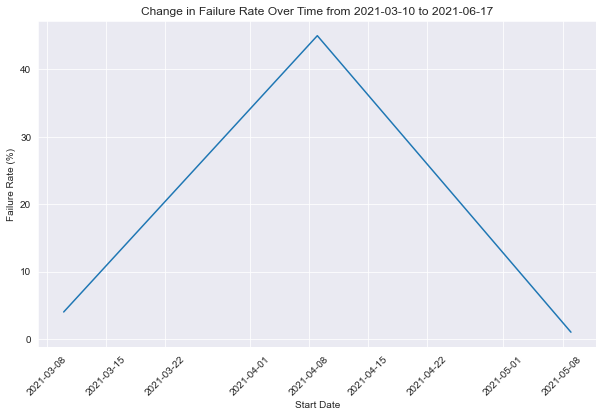

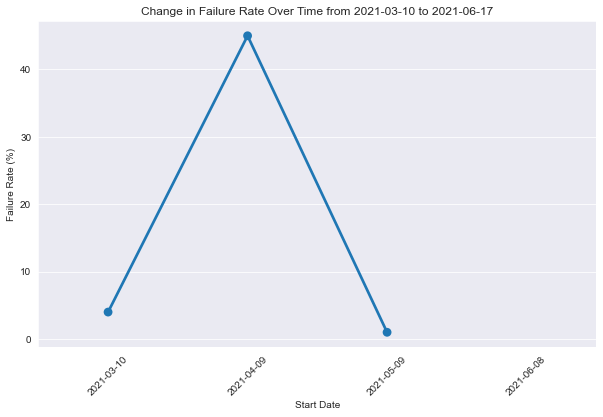

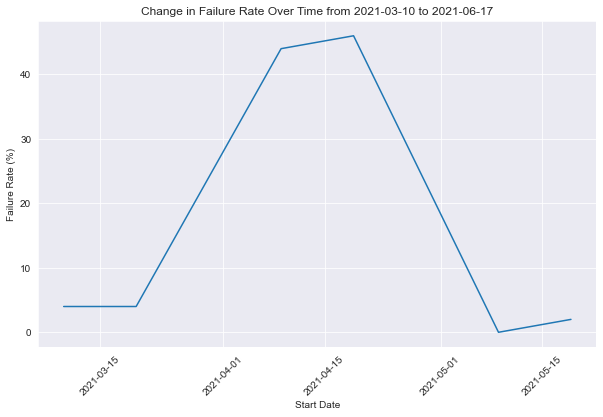

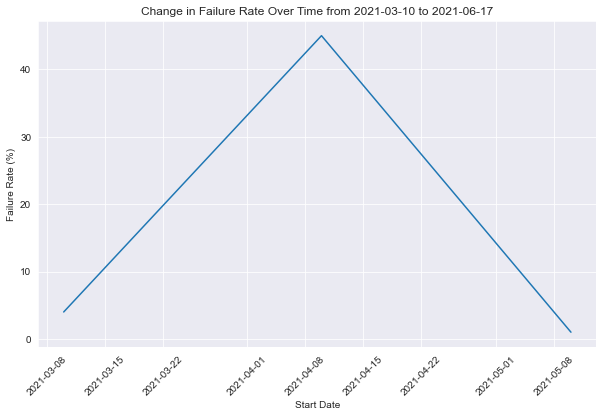

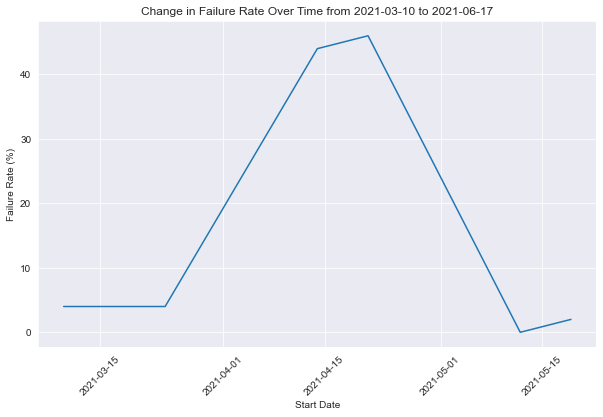

In [33]:
# Testing the failure over time function
failureOverTime(df, '2021-03-10', getDate(), 'day', 30)
failureOverTime(df, '2021-03-10', getDate(), 'day', 30, False)
failureOverTime(df, '2021-03-10', getDate(), 'day', 10)
failureOverTime(df, '2021-03-10', getDate(), 'month', 1)
failureOverTime(df, '2021-03-10', getDate(), 'week', 1)

In [ ]:
# Applying date filters to DF directly (instead of going through the SQL DB)
def beforeEntries(end):
    return df[df['Date'] <= end]
def afterEntries(start):
    return df[df['Date'] >= start]
def betweenEntries(start, end):
    return df[(df['Date'] >= start) & (df['Date'] <= end)]

In [ ]:
# Adding data labels: https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9

# Visualization with time constraint

# Create a graph visual over the past X days/weeks/months/years--choose the visual type
# Potential graph types: rawFail, relFail, failTypes
def visualFailTime(x, segType, graphType):
    if segType == 'day':
        tempEnd = dt.datetime.today() - pd.offsets.DateOffset(days = x) # Get the end date for end of a time chunk
    elif segType == 'month':
        tempEnd = dt.datetime.today()  - pd.offsets.DateOffset(months = x)
    elif segType == 'week':
        tempEnd = dt.datetime.today()  - pd.offsets.DateOffset(weeks = x)
    elif segType == 'year':
        tempEnd = dt.datetime.today()  - pd.offsets.DateOffset(years = x)
    tempEnd = tempEnd.strftime('%Y-%m-%d') 
    #print(tempEnd)
    relEntries = df[df['Date'] > tempEnd] # Only preserve the entries that are from relevant date onward
    #display(relEntries)
    if graphType == 'rawFail': 
        return compareFunctionalTests(relEntries, tempEnd)
    if graphType == 'relFail': # Generate the proportion of failures (relative)
        return relativeFunctionalTests(relEntries, tempEnd)
    if graphType == 'failTypes':
        return failureVisual(relEntries, tempEnd)

# Create a visual based off of the starting + ending date
def visualBetweenTime(start, end, graphType):
    relEntries = betweenEntries(start, end)
    if graphType == 'rawFail': 
        return compareFunctionalTests(relEntries, start, end)
    if graphType == 'relFail': # Generate the proportion of failures (relative)
        return relativeFunctionalTests(relEntries, start, end)
    if graphType == 'failTypes':
        return failureVisual(relEntries, start, end)


In [ ]:
# Testing the Visual Generation
visualFailTime(30, 'day', 'rawFail');
visualFailTime(10, 'week', 'relFail');
visualFailTime(4, 'month', 'failTypes');


### Everything beneath is outdated

In [ ]:
# client = boto3.client('rds-data')
# response = client.execute_statement(
#     secretArn = secretARN,
#     database = dbName,
#     resourceArn = resourceARN,
#     sql = 'Show Tables'
# )
# display(response['records'])


In [ ]:
# # Helper method to execute a SQL query
# def execute(q):
#     response = client.execute_statement(
#         secretArn = secretARN,
#         database = dbName,
#         resourceArn = resourceARN,
#         sql = q
#     )
#     return response

# # Execute longer queries for select statements (need to go possibly to > 1MB)
# def executeBatch(q):
#     responses = []
#     qTemp = ''' Select Count(*) from QAResults '''
#     numEntries = execute(qTemp)['records'][0][0]['longValue']
#     limit = 1000
#     #print('numEntries:', numEntries)
#     for i in range(numEntries//limit + 1):
#         response = client.execute_statement(
#             secretArn = secretARN,
#             database = dbName,
#             resourceArn = resourceARN,
#             sql = q + ' Limit {} Offset {}'.format(limit, i * limit)
#         )
#         #print(response)
#         responses.append(response['records'])
#     return responses

# #deleteTable()

In [ ]:

# # Create the basic table
# def createTable():
#     q = '''
#         Create table if not exists QAResults(
#             SerialNumber VARCHAR(30),
#             BatchNumber VARCHAR(30),
#             Date VARCHAR(10),
#             Tester VARCHAR(30),
#             FunctionalTest VARCHAR(4),
#             LogMessage text,
#             primary key (SerialNumber)
#         )
#     '''
#     return execute(q)

# # Simple method to return date in YYYY-MM-DD format
# def getDate():
#     return dt.datetime.today().strftime('%Y-%m-%d') # YYYY-MM-DD

# # Fetch an entry based off of serial number
# def getEntry(sn):
#     try:
#         q = ''' SELECT * FROM QAResults where SerialNumber = '{}' '''.format(sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with get entry:', e)

# # Helper method to insert an entry
# # sn, bn, date, tester, ft, log
# def insertEntry(sn, bn, ft, tst, msg, date = getDate()):
#     try:
#         q = ''' Insert into QAResults values ('%s', '%s', '%s', '%s', '%s', '%s')''' % (sn, bn, date, tst, ft, msg)
#         return execute(q)
#     except Exception as e:
#         print('Issue with add entry:', e)

# # Delete an entry based on SN alone
# def deleteEntry(sn):
#     try:
#         q = ''' Delete from QAResults where SerialNumber = '%s' ''' % (sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with delete entry:', e)

# # Modify a field based off of SN
# def modifyEntry(sn, field, newVal):
#     try:
#         q = ''' Update QAResults set {} = '{}' where SerialNumber = '{}' '''.format(field, newVal,sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with edit entry:', e)

# # Get all the results for the table
# def displayAll():
#     try:
#         print('\n\nQAResults Table\n')
#         q = ''' Select * From QAResults '''
#         records = executeBatch(q)
#         entries = records[0]
#         for r in entries:
#             print('Entry:', r)
#     except Exception as e:
#         print('Issue with displaying table:', e)

# # Delete the entire table
# def deleteTable():
#     try:
#         q = 'Drop Table QAResults'
#         return execute(q)
#     except Exception as e:
#         print('Issue while deleting table:', e)


In [ ]:

# # Initial Testing the framework above
# createTable()
# #displayAll() # After initial table creation
# insertEntry('EEE833134W0', 'E2', 'Pass', 'Zach', 'Everything works')
# insertEntry('EEE833134W1', 'E2', 'Fail', 'Ruohan','Everything works')
# insertEntry('EEE833134W2', 'E2','Fail', 'Ryan','Breakdown occurred')
# displayAll() # After insertion of entries
# modifyEntry('EEE833134W1', 'BatchNumber', 'F33')
# displayAll() # After modification of an entry
# deleteEntry('EEE833134W2')
# displayAll() # After deletion of an entry

In [ ]:

# # Functions + Variables to mass insert entries (consistently) into the database
# snPrefix = ['EUHWQ3931-', 'ABC22', 'RRH43144', '283367144']
# batchNums = ['EE1', 'FF2', 'GG3']
# testers = ['Zach', 'Ryan', 'Ruohan', 'Nikki', 'Megan']
# results = ['Pass', 'Fail']
# dates = [getDate(), '2020-05-02', '2020-06-09', '2019-11-27', '2021-04-19', '2021-04-01']
# messages = ['Camera issue', 'Night mode issue', 'Other issue-unlisted']
# passMsg = 'Everything works'

# def massInsertEntry(n):
#     for i in range(n):
#         sn = snPrefix[i % 4] + str(i)
#         bn = batchNums[i % 3]
#         t = testers[i % 5]
#         res = results[int(i % 4 == 0)]
#         d = dates[i % 6]
#         msg = passMsg if res == 'Pass' else messages[i % 3]
#         insertEntry(sn, bn, res, t, msg, d)
# massInsertEntry(50)
# displayAll()